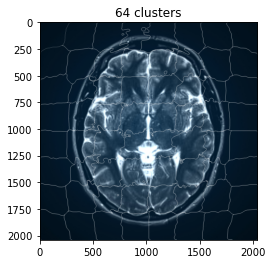

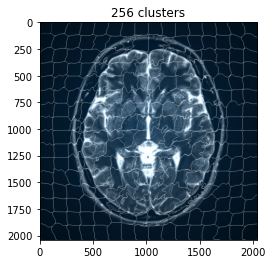

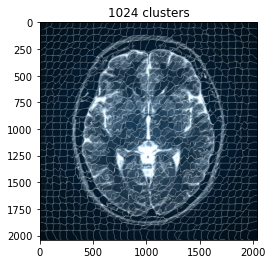

In [2]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import skimage.segmentation
import scipy.signal

# -----------------------------------


def find_segment_boundaries(score_matrix, image):

    scores = scipy.signal.medfilt2d(score_matrix[:, :], 29)

    boundaries = skimage.segmentation.find_boundaries(
        np.uint8(scores), mode='outer', connectivity=0.5).astype(bool)

    x, y = np.where(boundaries == 1)
    img = np.copy(image)
    img[x, y, :] = 255

    return img

# ----------------------------------


def calculate_euclidean_distance(x_array, y_array, x_i, y_i):

    distance = np.sqrt((x_array - x_i) ** 2 + (y_array - y_i) ** 2)

    return distance

# ----------------------------------


def perturb_cluster_centers(x_array, y_array, s_value, k_value, c1_value, c2_value, edge_array):

    for i in range(0, k_value):

        point = np.where(edge_array[max(x_array[i] - 2, 0): min(x_array[i] + 2, c1_value - 1),
                                    max(y_array[i] - 2, 0): min(y_array[i] + 2, c2_value - 1)]
                         == np.min(edge_array[max(x_array[i] - 2, 0): min(x_array[i] + 2, c1_value - 1),
                                               max(y_array[i] - 2, 0): min(y_array[i] + 2, c2_value - 1)]))

        x_array[i] = x_array[i] + point[0][0] - 2
        y_array[i] = y_array[i] + point[1][0] - 2

    return x_array, y_array, s_value, k_value
# ------------------------------------


def calculate_lab_distance(lab_array, l_i, a_i, b_i):

    l_channel = lab_array[:, :, 0]
    a_channel = lab_array[:, :, 1]
    b_channel = lab_array[:, :, 2]

    distance_lab = np.sqrt((l_channel - l_i) ** 2 + (a_channel - a_i) ** 2 + (b_channel - b_i) ** 2)

    return distance_lab


# -------------------------------


def plot_centroids(x_array, y_array, original_image, k_value):

    image_copy = np.copy(original_image)

    plt.imshow(image_copy)

    for i in range(0, k_value):
        plt.scatter(y_array[i], x_array[i], color='w', marker='.')

    return image_copy

# ---------------------------------------


def calculate_gradients(matrix):

    result = np.array(ndimage.sobel(matrix))

    return result

# ----------------------------------


def initialize_centroids(k_value, original_image, c1_value, c2_value):

    each_dimension = int(math.sqrt(k_value))

    distance1 = c1_value // each_dimension
    num1 = c1_value // distance1
    distance2 = c2_value // each_dimension
    num2 = c2_value // distance2

    s_total = max(distance1, distance2)
    k_value = num1 * num2

    x_array = []
    y_array = []

    for g in range(0, num1):
        for h in range(0, num2):
            x_array.append(distance1 // 2 + g * distance1)
            y_array.append(distance2 // 2 + h * distance2)

    return np.array(x_array), np.array(y_array), s_total, k_value

# ------------------------------------


def perform_slic_segmentation(x_array, y_array, k_value, s_value, image, lab_image):

    [c1_value, c2_value, c3_value] = image.shape

    scores = np.zeros([c1_value, c2_value])

    compare_matrix = np.ones([c1_value, c2_value]) * 1000000

    i_mat, j_mat = np.indices((c1_value, c2_value))

    for w in range(0, k_value):

        i = x_array[w]
        j = y_array[w]

        lab_temp = lab_image[max(
            i - s_value, 0): min(i + s_value, c1_value), max(j - s_value, 0): min(j + s_value, c2_value), :]

        lab_distance = calculate_lab_distance(
            lab_temp, lab_image[i, j, 0], lab_image[i, j, 1], lab_image[i, j, 2])

        xy_distance = calculate_euclidean_distance(
            i_mat[max(i - s_value, 0): min(i + s_value, c1_value), max(j - s_value, 0): min(j + s_value, c2_value)],
            j_mat[max(i - s_value, 0): min(i + s_value, c1_value), max(j - s_value, 0): min(j + s_value, c2_value)],
            i, j)

        total_distance = lab_distance + 0.1 * xy_distance

        x_f, y_f = np.where(total_distance[:, :] <= compare_matrix[max(i - s_value, 0): min(i + s_value, c1_value),
                                                                   max(j - s_value, 0): min(j + s_value, c2_value)])

        compare_matrix[max(i - s_value, 0) + x_f, max(j - s_value, 0) + y_f] = total_distance[x_f, y_f]

        scores[max(i - s_value, 0) + x_f, max(j - s_value, 0) + y_f] = w

    return scores


# -----------------------------------
original_image = cv2.imread('brain.jpg')
original_image = np.array(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
lab_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2Lab)

[c1, c2, c3] = original_image.shape

edge = calculate_gradients(gray_image)

for g in range(1, 4):

    k_value = 64 * (4 ** (g - 1))
    if g == 4:
        k_value = 2048

    x_array, y_array, s_value, k_value = initialize_centroids(k_value, original_image, c1, c2)

    x_array, y_array, s_value, k_value = perturb_cluster_centers(x_array, y_array, s_value, k_value, c1, c2, edge)

    scores = perform_slic_segmentation(x_array, y_array, k_value, s_value, original_image, lab_image)
    result = find_segment_boundaries(scores, original_image)
    k_value = 64 * (4 ** (g - 1))
    if g == 4:
        k_value = 2048

    plt.imsave(f'res{g}.jpg', result)
    plt.imshow(result)
    plt.title(f'{k_value} clusters')
    plt.show()